# Imports & Installation

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose                       
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Thesis/Datasets

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Datasets


In [4]:
df = pd.read_csv("cleaned.csv",parse_dates=["Date"],index_col=["Date"])

In [5]:
df.head(n = 10)

,No of purchases
Date,
2016-09-04,1
2016-09-05,1
2016-09-13,1
2016-09-15,1
2016-10-02,1
2016-10-03,8
2016-10-04,63
2016-10-05,47
2016-10-06,51


Data plot

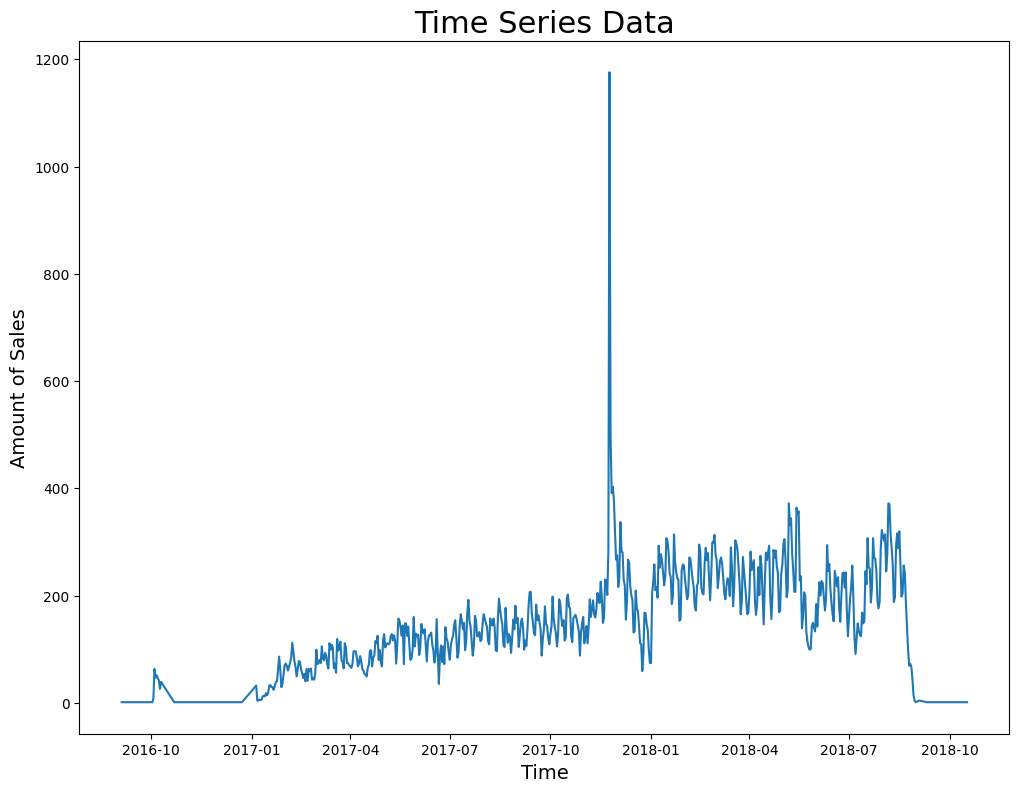

In [6]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(df)

# Set the axis labels and title
ax.set_xlabel('Time', fontsize = 14)
ax.set_ylabel("Amount of Sales", fontsize = 14)
ax.set_title('Time Series Data', fontsize = 22)
ax.set_facecolor('None')
fig.set_size_inches(12, 9)
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 634 entries, 2016-09-04 to 2018-10-17
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   No of purchases  634 non-null    int64
dtypes: int64(1)
memory usage: 9.9 KB


Check for missing values

In [8]:
df.isnull().sum()

No of purchases    0
dtype: int64

Log Transformation

In [12]:
# log transform to remove variation
df['log_transformed'] = np.log(df['No of purchases'])

Removal of Outliers (Z-score Method)

In [13]:
# First, calculate z-scores for the data
df['z_score'] = np.abs((df['log_transformed'] - df['log_transformed'].mean()) / df['log_transformed'].std())

# Next, remove any data points with a z-score greater than 3 (or any other threshold value you choose)
threshold = 3
df = df[df['z_score'] <= threshold]

# Finally, remove the 'z_score' column we created earlier
df = df.drop('z_score', axis=1)

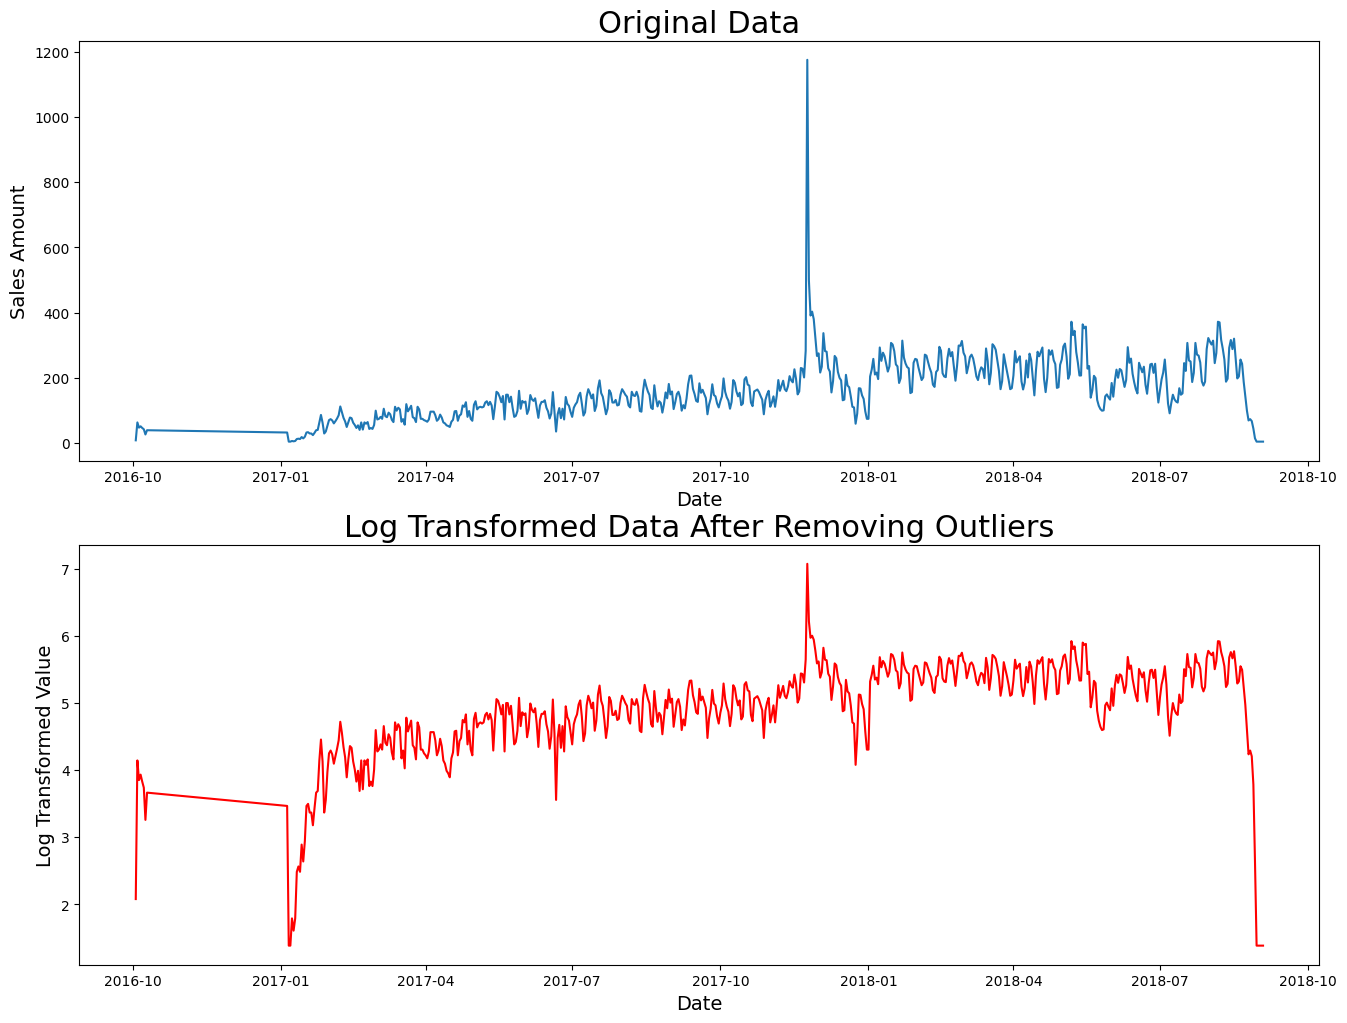

In [14]:
fig, ax = plt.subplots(2, 1)
ax[0].set_facecolor('None')
fig.set_size_inches(16, 12)
ax[0].plot(df['No of purchases'])
ax[0].set_title('Original Data', fontsize = 22)
ax[0].set_xlabel('Date', fontsize=14)
ax[0].set_ylabel('Sales Amount', fontsize=14)
ax[1].set_facecolor('None')

ax[1].plot(df['log_transformed'], color='red')
ax[1].set_title('Log Transformed Data After Removing Outliers', fontsize=22)
ax[1].set_xlabel('Date', fontsize=14)
ax[1].set_ylabel('Log Transformed Value', fontsize=14)
plt.show()

# Stationarity Test

In [15]:
def adf_test(timeseries):
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if dfoutput['p-value'] < 0.05:
      print('Data is stationary')
    else:
      print('Data is not stationary')

In [16]:
adf_test(df['log_transformed'])

Results of Augmented Dickey-Fuller Test:
Data is stationary


# Seasonal Decomposition

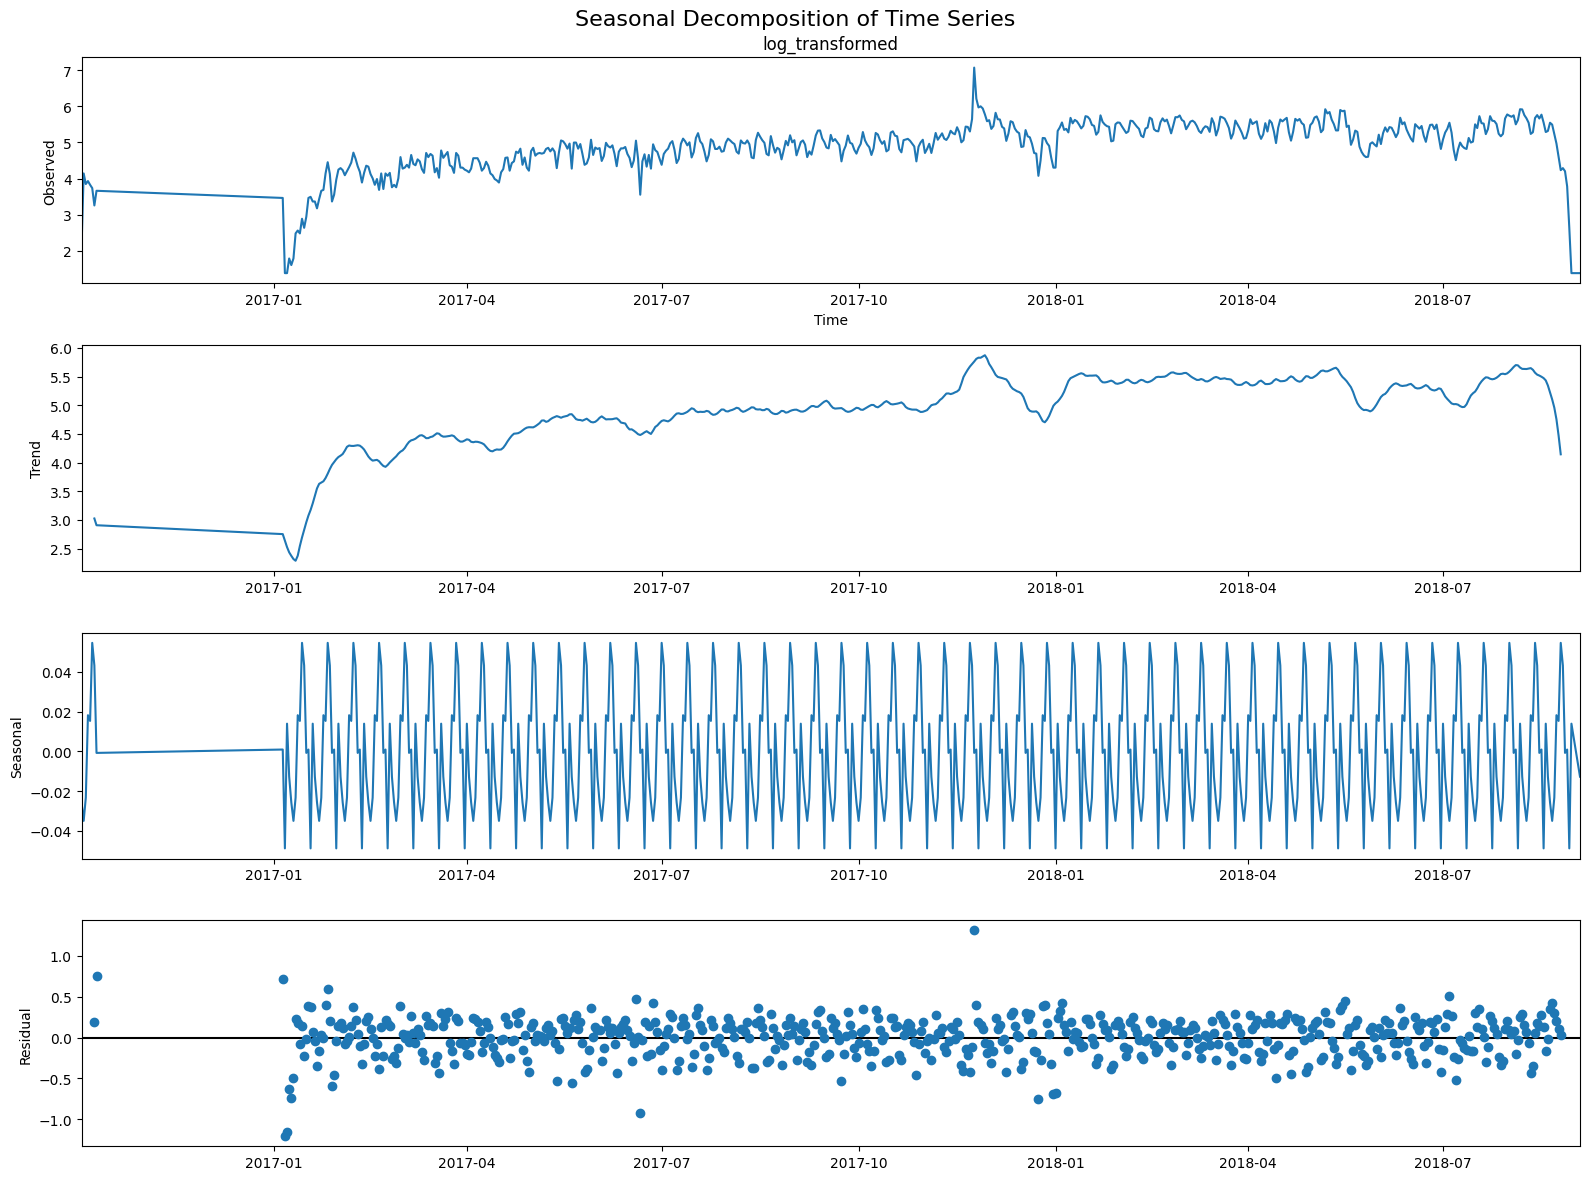

In [17]:
a = seasonal_decompose(df['log_transformed'], model = "additive",period=12)
fig = a.plot()
fig.set_size_inches(16, 12)
fig.set_facecolor('None')
fig.axes[0].set_xlabel('Time')
fig.axes[0].set_ylabel('Observed')
fig.axes[1].set_ylabel('Trend')
fig.axes[2].set_ylabel('Seasonal')
fig.axes[3].set_ylabel('Residual')
fig.axes[0].set_facecolor('None')
fig.axes[1].set_facecolor('None')
fig.axes[2].set_facecolor('None')
fig.axes[3].set_facecolor('None')

fig.suptitle('Seasonal Decomposition of Time Series', fontsize=16)
fig.tight_layout()
plt.show()


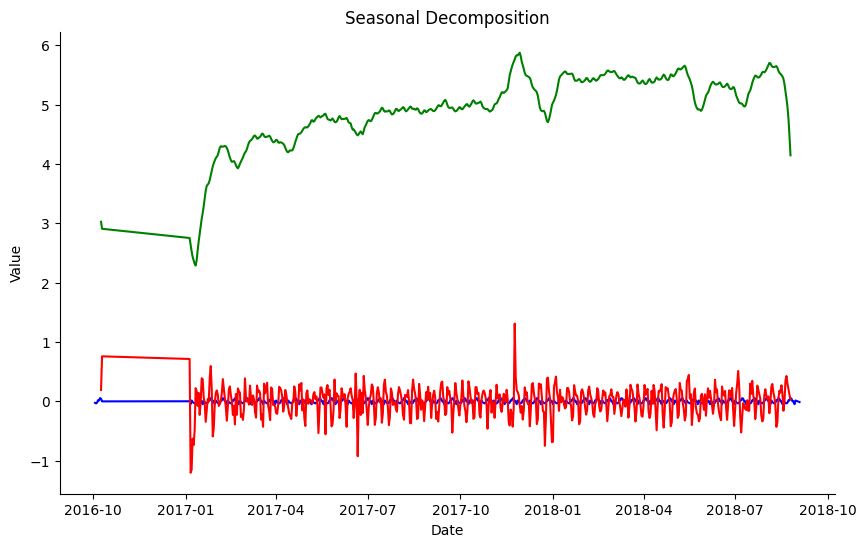

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(a.seasonal, color='blue')
ax.plot(a.trend, color='green')
ax.plot(a.resid, color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Seasonal Decomposition')
ax.set_facecolor('None')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

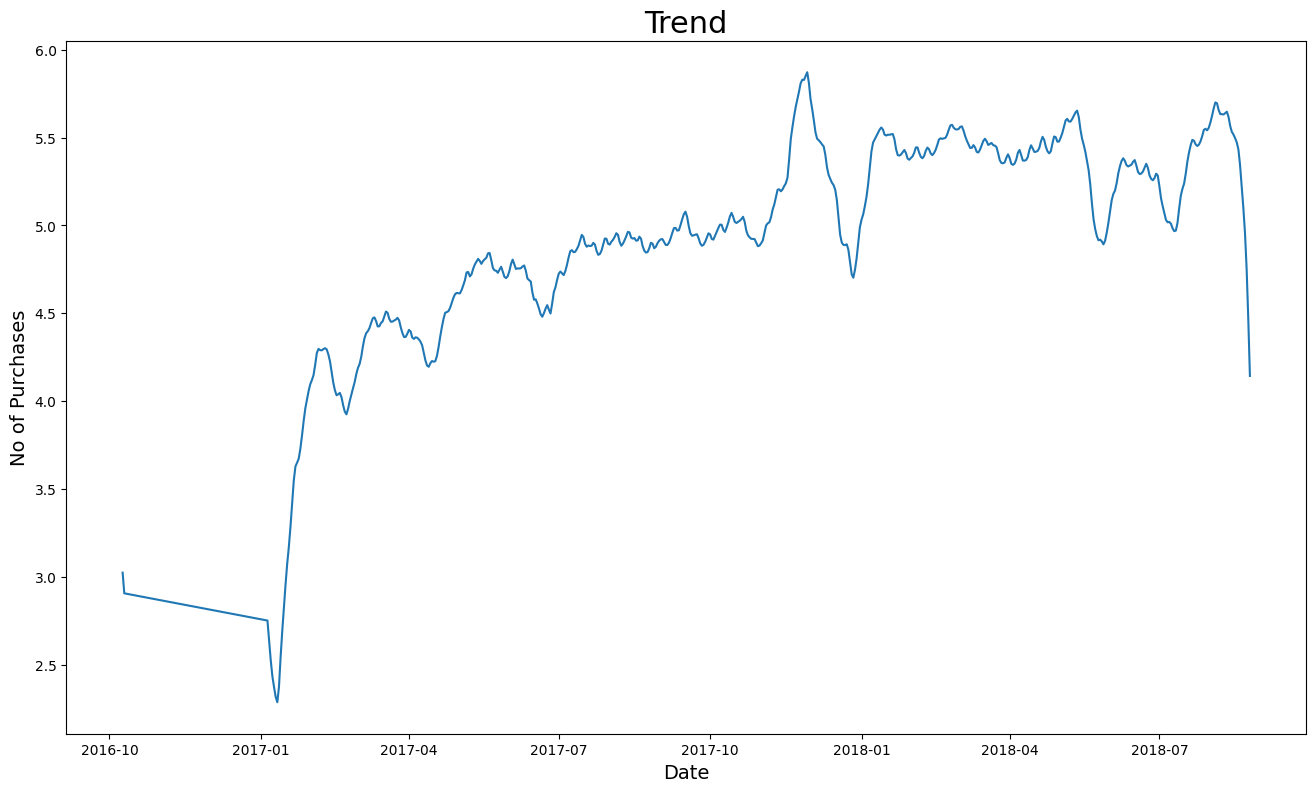

In [19]:
plt.figure(figsize=(16,9))
plt.title('Trend', fontsize = 22)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("No of Purchases", fontsize = 14)
plt.plot(a.trend)

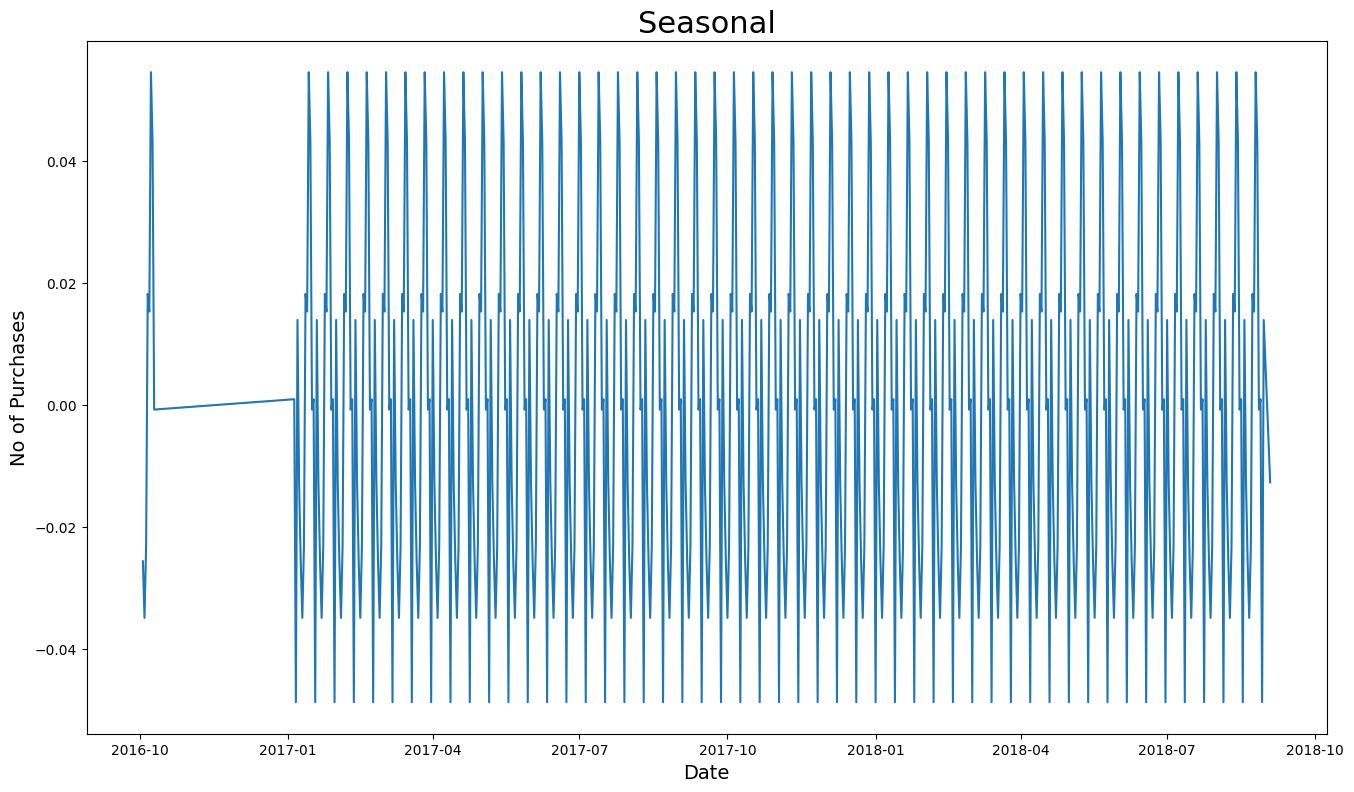

In [20]:
plt.figure(figsize=(16,9))
plt.title('Seasonal', fontsize = 22)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("No of Purchases", fontsize = 14)
plt.plot(a.seasonal)

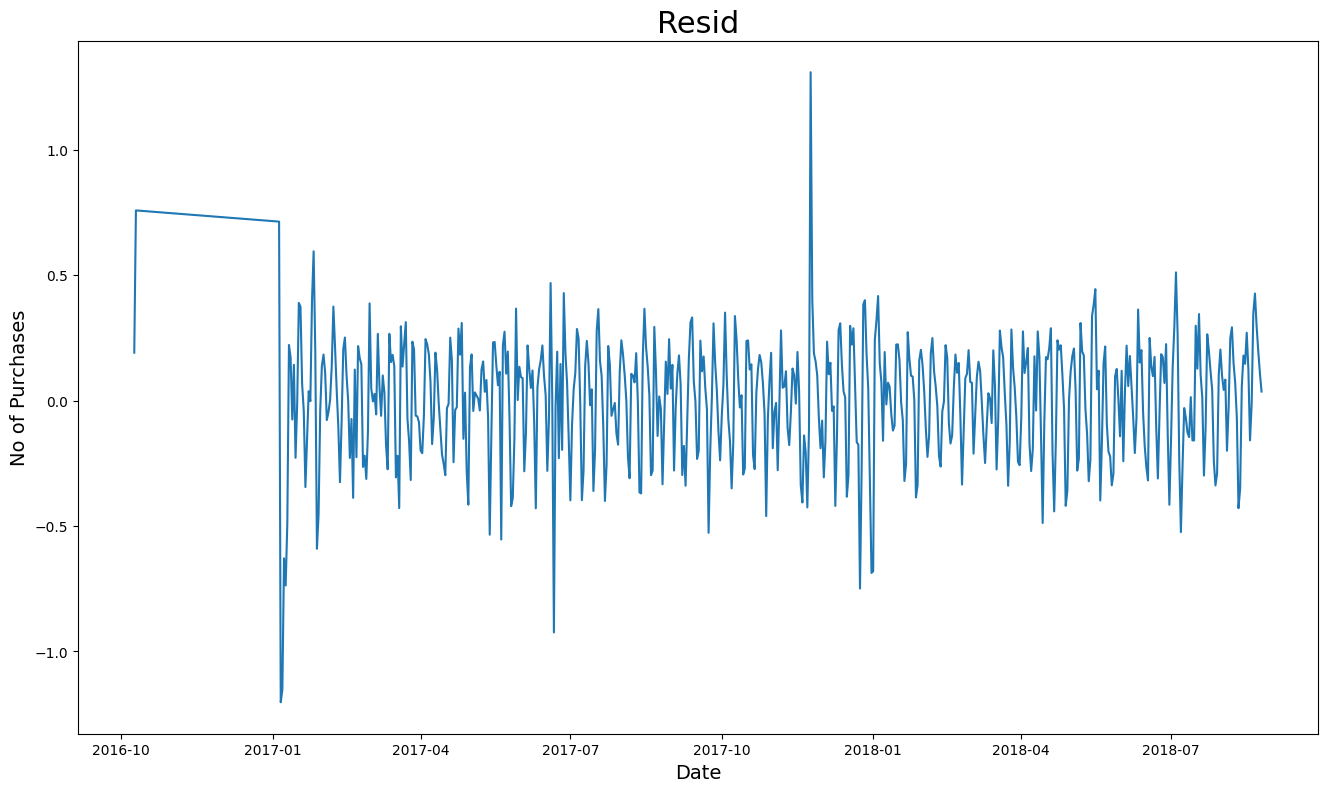

In [21]:
plt.figure(figsize=(16,9))
plt.title('Resid', fontsize = 22)
plt.xlabel("Date", fontsize = 14)
plt.ylabel("No of Purchases", fontsize = 14)
plt.plot(a.resid)

In [22]:
print(len(df))

612


# Training-Testing Split

In [23]:
l = len(df)
training_percentage = 80
m = round((l * training_percentage) / 100)
print(m)

490


In [24]:
train_data = df[:m]
test_data = df[m:]

In [25]:
print(train_data.shape)
print(test_data.shape)

(490, 2)
(122, 2)


In [26]:
train_data.tail()

,No of purchases,log_transformed
Date,,
2018-04-27,242,5.488938
2018-04-28,169,5.129899
2018-04-29,171,5.141664
2018-04-30,240,5.480639
2018-05-01,256,5.545177


In [27]:
test_data.head()

,No of purchases,log_transformed
Date,,
2018-05-02,296,5.690359
2018-05-03,305,5.720312
2018-05-04,265,5.579730
2018-05-05,197,5.283204
2018-05-06,211,5.351858


# Learning

In [28]:
am = auto_arima(df['log_transformed'], seasonal=True, m=12, max_p=7, max_d=5, max_q=7, max_P=4, max_D=4,max_Q=4)

In [29]:
print(am.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  612
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 12)   Log Likelihood                 -54.233
Date:                              Sat, 13 May 2023   AIC                            122.466
Time:                                      14:35:05   BIC                            153.372
Sample:                                           0   HQIC                           134.487
                                              - 612                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0010      0.007     -0.145      0.885      -0.014       0.012
ar.L1          1.21

In [30]:
arima_model = ARIMA(train_data['log_transformed'], order=(4,1,5), seasonal_order = (0,0,1,12))
arima_result = arima_model.fit()
print(arima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    log_transformed   No. Observations:                  490
Model:             ARIMA(4, 1, 5)x(0, 0, [1], 12)   Log Likelihood                 -18.161
Date:                            Sat, 13 May 2023   AIC                             58.322
Time:                                    14:35:47   BIC                            104.438
Sample:                                         0   HQIC                            76.435
                                            - 490                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2082      0.049      4.246      0.000       0.112       0.304
ar.L2         -0.5830      0.055   

# Prediction

In [31]:
arima_pred = arima_result.predict(start = 0, end = l-1, typ="levels").rename("ARIMA Predictions")
arima_pred = np.exp(arima_pred)

In [32]:
train_data_copy = train_data.copy() 
train_data_copy['ARIMA_Predictions'] = list(round(arima_pred[:m]))
test_data_copy = test_data.copy() 
test_data_copy['ARIMA_Predictions'] = list(round(arima_pred[m:]))

In [33]:
train_data_copy.head()

,No of purchases,log_transformed,ARIMA_Predictions
Date,,,
2016-10-03,8,2.079442,1.0
2016-10-04,63,4.143135,8.0
2016-10-05,47,3.850148,44.0
2016-10-06,51,3.931826,32.0
2016-10-07,46,3.828641,40.0


In [34]:
test_data_copy.head()

,No of purchases,log_transformed,ARIMA_Predictions
Date,,,
2018-05-02,296,5.690359,243.0
2018-05-03,305,5.720312,219.0
2018-05-04,265,5.579730,196.0
2018-05-05,197,5.283204,177.0
2018-05-06,211,5.351858,200.0


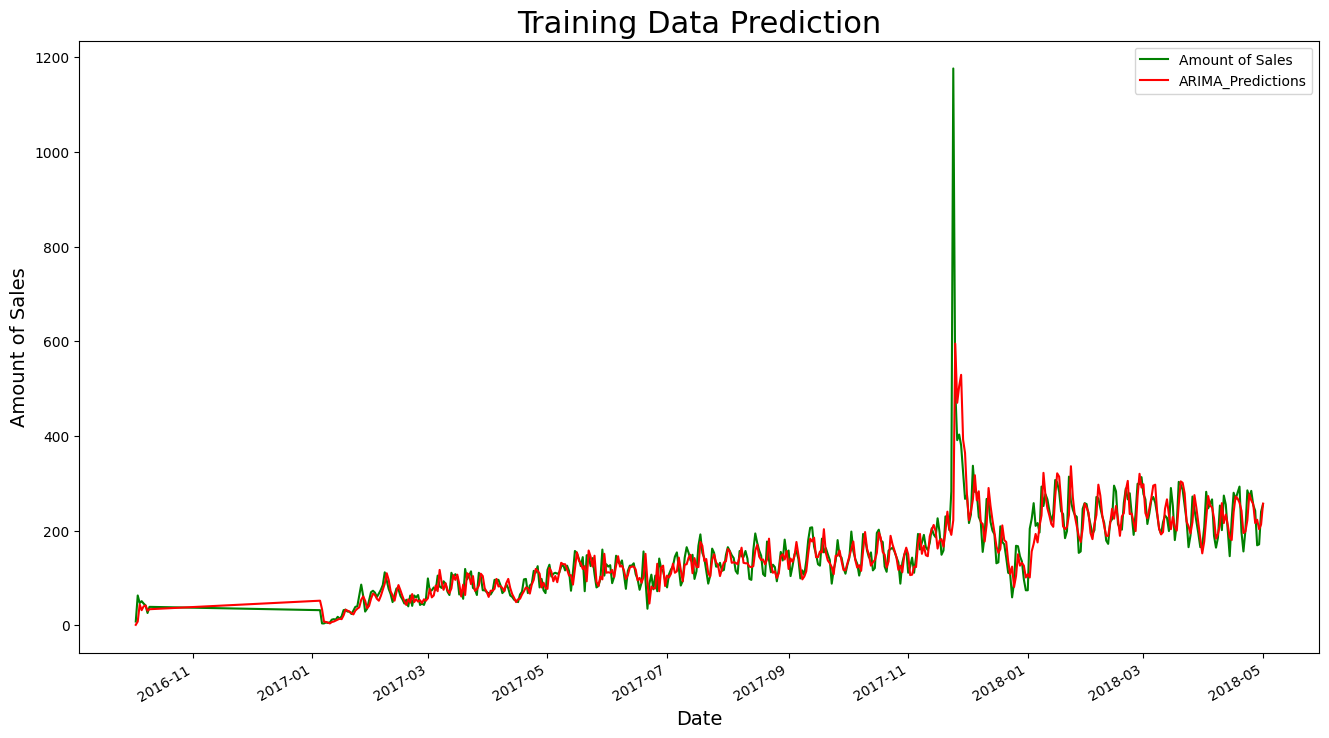

In [35]:
fig, ax = plt.subplots(figsize=(16, 9), facecolor='None')
train_data_copy['No of purchases'].plot(legend=True, label='Amount of Sales', color='green', ax=ax)
train_data_copy['ARIMA_Predictions'].plot(legend=True, color='red', ax=ax)
ax.set_title('Training Data Prediction', fontsize=22)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Amount of Sales", fontsize=14)
ax.set_facecolor('None')
plt.show()


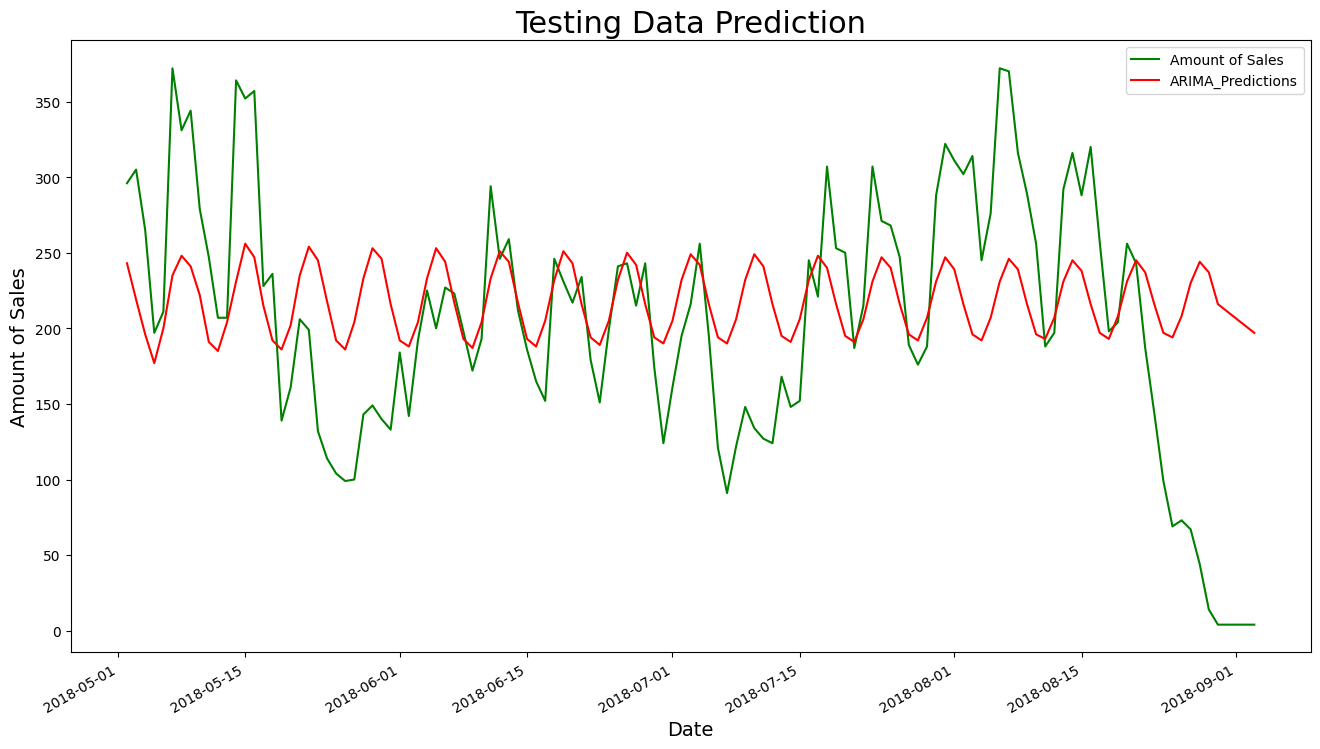

In [36]:
fig, ax = plt.subplots(figsize=(16, 9), facecolor='None')
test_data_copy['No of purchases'].plot(legend=True, label='Amount of Sales', color='green', ax=ax)
test_data_copy['ARIMA_Predictions'].plot(legend=True, color='red', ax=ax)
ax.set_title('Testing Data Prediction', fontsize=22)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Amount of Sales", fontsize=14)
ax.set_facecolor('None')
plt.show()


# Errors

Training Data

In [37]:
arima_rmse_error = round(rmse(train_data['No of purchases'], arima_pred[:m]),4)
arima_mse_error = arima_rmse_error**2
mean_value = df['No of purchases'].mean()
r2_score_arima = round(r2_score(train_data['No of purchases'],arima_pred[:m]), 4) 
MAPE_arima = round(mean_absolute_percentage_error(train_data['No of purchases'], arima_pred[:m]), 4)
MAD_arima = arima_pred.mad()
MAE_arima = round(mean_absolute_error(train_data['No of purchases'], arima_pred[:m]), 4)

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}\nr2_score : {r2_score_arima}\nMAPE : {MAPE_arima}\nMAD : {MAD_arima}\nMAE: {MAE_arima}')

MSE Error: 2658.79453225
RMSE Error: 51.5635
Mean: 162.44607843137254
r2_score : 0.6707
MAPE : 0.1757
MAD : 63.367136560826005
MAE: 22.5406


Testing Data

In [38]:
arima_rmse_error = round(rmse(test_data['No of purchases'], arima_pred[m:]),4)
arima_mse_error = round(arima_rmse_error**2,4)
mean_value = df['No of purchases'].mean()
r2_score_arima = round(r2_score(test_data['No of purchases'],arima_pred[m:]),4) 
MAPE_arima = round(mean_absolute_percentage_error(test_data['No of purchases'], arima_pred[m:]),4)
MAD_arima = arima_pred.mad()
MAE_arima = round(mean_absolute_error(test_data['No of purchases'], arima_pred[m:]),4)

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}\nr2_score : {r2_score_arima}\nMAPE : {MAPE_arima}\nMAD : {MAD_arima}\nMAE: {MAE_arima}')

MSE Error: 5567.3684
RMSE Error: 74.6148
Mean: 162.44607843137254
r2_score : 0.1174
MAPE : 1.2961
MAD : 63.367136560826005
MAE: 57.4313
